<a href="https://colab.research.google.com/github/hashimmg/jax_IB/blob/main/Flapping_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import numpy as np
import tree_math as tm
import jax
import jax.numpy as jnp
from jax_ib.base import particle_class as pc
from jax_ib.base import grids, fast_diagonalization, boundaries, pressure, diffusion, advection, finite_differences, IBM_Force,convolution_functions,particle_motion, equations
import jax_cfd.base as cfd
import jax_ib.MD as MD
from jax import random
from jax_md import space, quantity
import jax_ib
import jax_ib.base as ib
from jax_ib.base import kinematics as ks
from jax.random import uniform as random_uniform
import matplotlib.pyplot as plt
import functools as fct
import scipy 
import tree_math
from jax_ib.base import array_utils

In [46]:
from functools import partial

import jax
import jax.numpy as jnp

from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map

In [47]:
jax.devices()

[CudaDevice(id=0),
 CudaDevice(id=1),
 CudaDevice(id=2),
 CudaDevice(id=3),
 CudaDevice(id=4),
 CudaDevice(id=5),
 CudaDevice(id=6),
 CudaDevice(id=7)]

<font size="5"> Velocity fields live on the boundary surfaces between cells (offsets for vx and vy are  (1,0.5) and (0.5, 1)). Pressure lives at the cell center at offset = (0.5,0.5)<font size="5">v

In [48]:

density = 1.0    # fluid density
viscosity = 0.05 # fluid viscocity
dt=1e-4          # time step 

num_boundaries = 4 # in two dimensions there are 4 boundaries

domain = ((0,15.),(0,15.0))
size=(600,600)
grid = grids.Grid(size, domain=domain) #gridpoints in 

bc_fns = [lambda t: 0.0 for _ in range(num_boundaries)] #define boundary functions
vx_bc=((bc_fns[0](0.0), bc_fns[1](0.0)), (bc_fns[2](0.0),bc_fns[3](0.0)))
vy_bc=((0.0, 0.0), (0, 0.0))

velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))

vx_fn = lambda x, y: jnp.zeros_like(x)
vy_fn = lambda x, y: jnp.zeros_like(x)

vx_0, vy_0 = tuple(
    [
       grids.GridVariable
        (
           grid.eval_on_mesh(fn = lambda x, y: jnp.zeros_like(x), offset = offset), bc # initial values for fluid velocities are 0 both in x and y direction
        ) 
        for offset, bc in zip(grid.cell_faces,velocity_bc)
    ]
)
v0 = (vx_0, vy_0)
pressure0 = grids.GridVariable(
    grids.GridArray(jnp.zeros(grid.shape), grid.cell_center, grid), 
    boundaries.get_pressure_bc_from_velocity((vx_0, vy_0)))

<font size="5"> Immersed Boudary Kinematics <font size="5">

In [55]:
#-- Immersed objects

# Immersed Objects Geometery and Initial locations
# object is described by center of the object
# theta is here a dummy variable; if f-term was used in addition to the f_b term, we'd need theat
def ellipse(geometry_param, ntheta=200):
    A = geometry_param[0]
    B = geometry_param[1]

    xt = jnp.linspace(-A,A,ntheta)
    yt = B/A*jnp.sqrt(A**2-xt**2)
    xt_2 = jnp.linspace(A,-A,ntheta)[1:-1]
    yt2 = -B/A*jnp.sqrt(A**2-xt_2**2)
    return jnp.append(xt,xt_2),jnp.append(yt,yt2)

def ellipse_trajectory(ellipse_parameters, initial_center_of_mass_position, angular_rotation_speed, 
                       center_of_mass_motion_parameters, t):
    x, y = ellipse(ellipse_parameters, 200)
    amplitude, frequency = center_of_mass_motion_parameters
    center_of_mass = initial_center_of_mass_position - jnp.array([amplitude/2 * jnp.cos(2*jnp.pi*frequency*t), 0.0])
    xp = x*jnp.cos(angular_rotation_speed*t)-y*jnp.sin(angular_rotation_speed*t)+center_of_mass[0]                                                                                  
    yp = x*jnp.sin(angular_rotation_speed*t)+y*jnp.cos(angular_rotation_speed*t)+center_of_mass[1] 
    return xp, yp

In [56]:

particle_geometry_param = jnp.array([[0.1,0.5]])
particle_center_position = jnp.array([[domain[0][1]*0.75,domain[1][1]*0.5]]) #could be an array for multiple objects

# Immersed Objects kinematics
displacement_param = jnp.array([[2.8,0.25]])
rotation_param = jnp.array([jnp.pi/2])

ellipse_position = fct.partial(ellipse_trajectory, *[particle_geometry_param[0],particle_center_position[0], rotation_param[0], 
                                                     displacement_param[0]])
grad_ellipse_position = jax.jacrev(ellipse_position)

In [57]:
inner_steps = 10#1800#20#450#1500#1300
outer_steps = 10#6000#12000#3000#2000#4500#4500#1800#10#900#20 (18000 works well to reach steady state)

#-- Setup Pytree Variable to be looped over during integration steps

Intermediate_calcs = [0] ## If one is interested to perform post-calculation without the need to save large trajectories
Step_counter = 0
MD_state = [0] # Needed when combinting Brownian integration with the Immersed Boundary simulation

all_variables = pc.All_Variables(v0,pressure0,Intermediate_calcs,Step_counter,MD_state)


<font size="5"> Simulation Setup <font size="5">

In [58]:

#-- IB force coupling functions
def internal_post_processing(all_variables,dt):
    return all_variables

# Convolution Discretized Integral
surf_fn =  lambda field,xp,yp:convolution_functions.convolve(field,xp,yp,convolution_functions.gaussian)

IBM_forcing = lambda velocities,t,dt: IBM_Force.immersed_boundary_force(velocities,
                                                                        [ellipse_position],
                                                                        convolution_functions.gaussian,
                                                                        surf_fn,
                                                                        t,
                                                                        dt)


In [59]:
# Update particle position function
def convect(v):
    return tuple(advection.advect_upwind(u, v, dt) for u in v)

single_step = ib.equations.semi_implicit_navier_stokes_timeBC(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve= ib.pressure.solve_fast_diag, #only works for periodic boundary conditions
        forcing=None, #pfo.arbitrary_obstacle(flow_cond.pressure_gradient,perm_f),
        time_stepper= ib.time_stepping.forward_euler_updated, #use runge-kutta , and keep it like that
        IBM_forcing = IBM_forcing, #compute the forcing term to update the particle
        Drag_fn = internal_post_processing, ### TO be removed from the example
        )
step_fn = cfd.funcutils.repeated(single_step, steps=inner_steps)

rollout_fn = cfd.funcutils.trajectory(
        step_fn, outer_steps, start_with_input=True)
final_result, trajectory = jax.device_get(rollout_fn(all_variables))


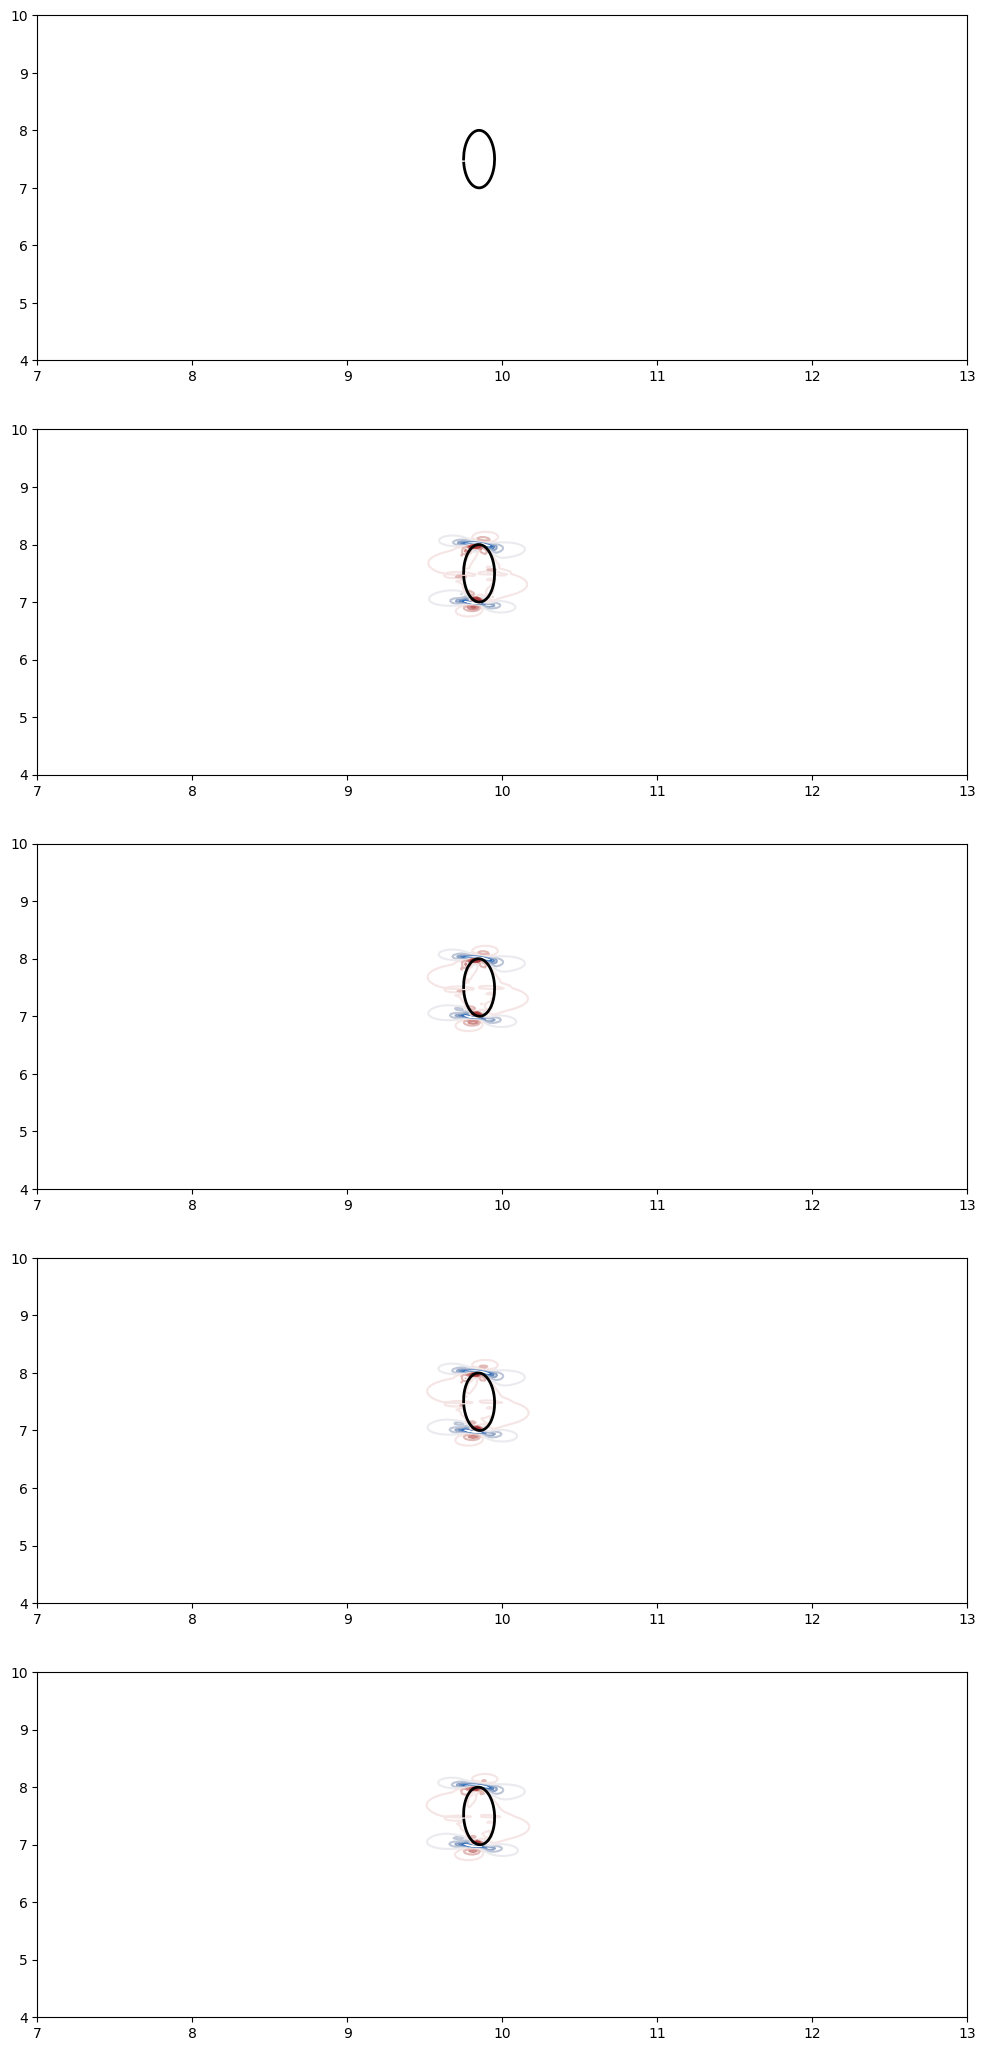

In [60]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np

X,Y = grid.mesh(grid.cell_center)



def calc_vorticity(trajectory,idx):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=trajectory.velocity[0].bc.time_stamp[idx]),
           boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=trajectory.velocity[0].bc.time_stamp[idx]))


    velocity = (grids.GridVariable(grids.GridArray(trajectory.velocity[0].data[idx], trajectory.velocity[0].offset, trajectory.velocity[0].grid), vel_bc[0]),
                     grids.GridVariable(grids.GridArray(trajectory.velocity[1].data[idx], trajectory.velocity[1].offset, trajectory.velocity[1].grid), vel_bc[1]))

    return finite_differences.central_difference(velocity[1], axis=1).data- finite_differences.central_difference(velocity[0], axis=1).data



fig,ax = plt.subplots(figsize=(12,26),nrows=outer_steps//2)

idx = 2
counter=0
for idx in range(0,outer_steps,2):
    ax[counter].contour(X,Y,calc_vorticity(trajectory,idx),cmap=seaborn.color_palette("vlag", as_cmap=True),levels=np.linspace(-10, 10, 10))
    current_t = trajectory.velocity[0].bc.time_stamp[idx]
    xp, yp = ellipse_position(current_t)
    ax[counter].set_xlim([7,13])
    ax[counter].set_ylim([4,10])
    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1
